# Contents
 1. Setup
     - Imports
     - Parameters
     - Function Definitions
         - File Operations
         - Loading Experiment Data
         - Creating and Plotting Scenarios
         - Plotting Results
     - Create Scenarios
 2. SpiderBUG Control
     - Load Paths
     - Plot Paths
 3. Comparison to Comparable Planners
     - Build Dataframe
     - Plot Path Comparisons
 4. Hyper-Parameter Experiment
     - Load the Data
     - Plot the Data
         - Resolutions
         - Tolerances
 5. Vehicular Model Experiment
     - Load the Data
     - Plot the Data
 6. Dynamic Environment Experiment
     - Load the Data
     - Plot the Data
 7. Performance Experiments
     - Load the Data
     - Plot the Data

# 1. Setup
## 1.1 Imports

In [1]:
import os
import csv
import dubins
import math
import scipy.stats

import dill as pickle
import numpy as np
import pandas as pd
import seaborn as sns

from copy import copy
from sklearn import preprocessing


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.transforms import Affine2D

## 1.2 Parameters

In [2]:
turn_radius = 0.3
resolution = math.pi / 64
step_size = 0.05
ol = 0.5
base_dir = "exp_data\\"

## 1.3 Function Definitions

### 1.3.1 File Operations

In [3]:
def open_csv(base_dir, s_experiment, s_csv, n_scenario, n_iteration):
    f_name = str(base_dir) + str(s_experiment) + "\\S_" + str(n_scenario) + "\\i_" \
        + str(n_iteration) + "\\" + str(s_csv) + "_" + str(n_scenario) + ".csv"
    return open(f_name, newline='')

def open_path(base_dir, s_experiment, n_path, n_scenario, n_iteration):
    f_name = str(base_dir) + str(s_experiment) + "\\S_" + str(n_scenario) + "\\i_" \
        + str(n_iteration) + "\\py_objs\\" + str(n_path) + "_path.po"
    return open(f_name, 'rb')

def exists_csv(base_dir, s_experiment, s_csv, n_scenario, n_iteration):
    f_name = str(base_dir) + str(s_experiment) + "\\S_" + str(n_scenario) + "\\i_" \
        + str(n_iteration) + "\\" + str(s_csv) + "_" + str(n_scenario) + ".csv"
    return os.path.isfile(f_name)

### 1.3.2 Loading Experiment Data

Helper Functions:

In [4]:
def circleRadiusFromPoints(A, B, C):
    """
    Get the radius of the circle formed by points A, B, C.
    A, B, C are of type numpy array or list
    """
    if A == B or A == C or B == C:
        return math.inf
    yDelta_a = B[1] - A[1]
    xDelta_a = B[0] - A[0]
    yDelta_b = C[1] - B[1]
    xDelta_b = C[0] - B[0]
    center = [0, 0]

    aSlope = yDelta_a/xDelta_a
    bSlope = yDelta_b/xDelta_b
    if aSlope == bSlope:
        return math.inf

    AB_Mid = [(A[0]+B[0])/2, (A[1]+B[1])/2]
    BC_Mid = [(B[0]+C[0])/2, (B[1]+C[1])/2]

    if(yDelta_a == 0):
        center[0] = AB_Mid[0]
        if (xDelta_b == 0):
            center[1] = BC_Mid[1]
        else:
            center[1] = BC_Mid[1] + (BC_Mid[0] - center[0])/bSlope
    elif (yDelta_b == 0):
        center[0] = BC_Mid[0]
        if (xDelta_a == 0):
            center[1] = AB_Mid[1]
        else:
            center[1] = AB_Mid[1] + (AB_Mid[0]-center[0])/aSlope
    elif (xDelta_a == 0):
        center[1] = AB_Mid[1]
        center[0] = bSlope*(BC_Mid[1]-center[1]) + BC_Mid[0]
    elif (xDelta_b == 0):
        center[1] = BC_Mid[1]
        center[0] = aSlope*(AB_Mid[1]-center[1]) + AB_Mid[0]
    else:
        center[0] = (aSlope*bSlope*(AB_Mid[1]-BC_Mid[1]) - aSlope*BC_Mid[0] + bSlope*AB_Mid[0])/(bSlope-aSlope)
        center[1] = AB_Mid[1] - (center[0] - AB_Mid[0])/aSlope

    return math.sqrt((center[0] - A[0]) ** 2. + (center[1] - A[1]) ** 2.)    

Evaluate Smoothness:

In [5]:
def eval_smoothness(path, length):
    """
    From a given path and path-length calculate mean curvature and total-bending-energy (TBE)
    """
    tbe = 0
    curvatures = []
    # loop path points
    for i in np.arange(1, len(path[0])-2):
        cur = (path[0][i],   path[1][i])   # current point
        prv = (path[0][i-1], path[1][i-1]) # previous point
        nxt = (path[0][i+1], path[1][i+1]) # next point

        # get the current curvature
        curvature_cur = 1. / circleRadiusFromPoints(prv, cur, nxt)

        # normalise the curvature by the segment length over total path length
        norm_p = (math.sqrt((nxt[0] - cur[0]) ** 2. + (nxt[1] - cur[1]) ** 2.)) / length
        norm_curvature_cur = curvature_cur * length
        curvatures.append(norm_curvature_cur * norm_p)
    
        # add bending energy to total bending energy
        tbe += math.pow(norm_curvature_cur, 2) * norm_p

    if len(curvatures) == 0:
        mean_curv = 0
    else:
        mean_curv = np.mean(curvatures)
        
    # return average curvature and total bending energy
    return mean_curv, tbe

Evaluate length:

In [6]:
def eval_length(path):
    """
    Finds the total path length
    """
    t_len = 0.
    (p_x_0, p_y_0) = path[0][0], path[1][0] # previous point
    for (p_x, p_y) in zip(path[0], path[1]): # loop current point
        t_len += math.sqrt((p_x - p_x_0) ** 2. + (p_y - p_y_0) ** 2.)
        p_x_0, p_y_0 = p_x, p_y
    return t_len

Evaluate the Planner

In [7]:
def eval_planning_updates(up_path):
    """
    From the points where planning updates were initiated, calculate the mean update distance, the number of
    behaviour switches between MTG and BF and the proportion of successful updates
    """
    switches = 0
    last_mode = "mtg"
    successful_updates = 0
    last_point = up_path[0][:3]
    t_length = 0.
    for state in up_path:
        point = state[:3]
        new_mode = state[3]
        plan_success = state[4]
        len_t = math.sqrt((last_point[0] - point[0]) ** 2. + (last_point[1] - point[1]) ** 2.)
        t_length += len_t
        if new_mode != last_mode or plan_success == 0:
            switches += 1
            last_mode = new_mode
        if plan_success == 1:
            successful_updates += 1
        last_point = point
    return t_length / len(up_path), switches, successful_updates / len(up_path)

Evaluate final score

In [8]:
def eval_score(final_state, length_diff, av_curvature, tbe, n_switches, av_update_dist, prop_successful_updates):
    """
    ideal would be:
        final_state  == 1
        length_diff  == 0
        av_curvature == 0
        tbe          == 0
        n_switches   ~  [1..5]
        av_update_dist          == 0
        prop_successful_updates == 1
    This function sums the above parameters (or 1-the parameter) to give a score between 0 and 7. 
    A score of 0 is most desirable.
    """
    if final_state == 2:
        return 5 + av_update_dist + (1 - prop_successful_updates)
    return abs(final_state - 1) + length_diff + av_curvature + tbe + n_switches + av_update_dist \
        + (1 - prop_successful_updates)

Load all data and use above functions to evaluate

In [9]:
# final state: 0=running, 1=complete, 2=crash
def load_data(config_keys, csv_fname, exp_dname, scenarios=[1, 2, 3, 4, 5, 6], iterations=np.arange(0, 22), eval_s=True):
    """
    Loads the data from disk. 
    Parameters:
        config_keys: config parameters tested
        csv_fname:   csv prefix
        exp_dname:   experiment folder name
        scenarios:   the scenarios to load
        iterations:  the iterations to load
        eval_s:      if smoothness should contribute to the score
    """
    # init data frame
    df_ = pd.DataFrame(columns=["scenario", "iteration", *config_keys, "final_state", "path_all", "path_update"])
    # loop all scenarios
    for s in scenarios:
        # loop all iterations
        for i in iterations:
            # check csv exists
            if not exists_csv(base_dir, exp_dname, csv_fname, s, i):
                continue
            with open_csv(base_dir, exp_dname, csv_fname, s, i) as csvfile:
                csvReader = csv.reader(csvfile, delimiter=',')
                # loop all rows
                for j, row in enumerate(csvReader):
                    if j != 0 and len(row) == len(config_keys)+2: # skip header row and incomplete rows
                        with open_path(base_dir, exp_dname, row[-1], s, i) as pyf:
                            # load executed path and update path from files
                            (r_path, up_path) = pickle.load(pyf)
                            # append goal position to successful paths (as the robot stops short of the goal)
                            if float(row[-2]) < 2:
                                r_path[0].append(8.)
                                r_path[1].append(0.)
                            # append data to dataframe
                            df_ = df_.append({
                                "scenario": int(s),
                                "iteration":  int(i),
                                **{k:float(z) for k, z in zip(config_keys, row[:len(config_keys)])},
                                "final_state": float(row[-2]),
                                "path_all": r_path,
                                "path_update": up_path,
                                }, ignore_index=True)

    # evaluate path length
    df_["length"] = df_.apply(lambda row: eval_length(row["path_all"]), axis=1)
    
    # evaluate path length - optimal length
    df_["length_diff"] = df_.apply(lambda row: abs(row["length"] - scenarios_d[row["scenario"]]['ref_length']), axis=1)
    
    # evaluate planner metrics
    df_[['av_update_dist', 'n_switches', 'prop_suc_updates']] = \
        df_.apply(lambda row: eval_planning_updates(row["path_update"]), axis=1, result_type="expand")

    # evaluate smoothness
    df_[['av_curvature', 'tbe']] = \
        df_.apply(lambda row: eval_smoothness(row["path_all"], row["length"]), axis=1, result_type="expand")

    # calculate normalised metrics
    for scen in scenarios:
        min_max_scaler = preprocessing.MinMaxScaler()
        df_.loc[(df_['scenario'] == scen), ('length_diff_n', 'av_update_dist_n', 'prop_suc_updates_n', 'av_curvature_n', 'n_switches_n', 'tbe_n')] = \
            min_max_scaler.fit_transform(df_.loc[(df_['scenario'] == scen)][['length_diff', 'av_update_dist', 'prop_suc_updates', 'av_curvature', 'n_switches', 'tbe']])
    
    # evaluate score
    if eval_s:
        df_['score'] =  df_.apply(lambda row: \
             eval_score(row["final_state"], row["length_diff_n"], row["av_curvature_n"], row["tbe_n"], row["n_switches_n"], row["av_update_dist_n"], row["prop_suc_updates"]), axis=1)
             #          final_state,         length_diff,         av_curvature,          tbe,            n_switches,         av_update_dist,           prop_successful_updates
    else:
        df_['score'] =  df_.apply(lambda row: \
             eval_score(row["final_state"], row["length_diff_n"], 0, 0, row["n_switches_n"], row["av_update_dist_n"], row["prop_suc_updates"]), axis=1)
             #          final_state,         length_diff,         av_curvature,          tbe,            n_switches,         av_update_dist,           prop_successful_updates
    
    # subdivide dataframe per scenario
    df_s_1 = df_.loc[(df_['scenario'] == 1)]
    df_s_2 = df_.loc[(df_['scenario'] == 2)]
    df_s_3 = df_.loc[(df_['scenario'] == 3)]
    df_s_4 = df_.loc[(df_['scenario'] == 4)]
    df_s_5 = df_.loc[(df_['scenario'] == 5)]
    df_s_6 = df_.loc[(df_['scenario'] == 6)]
    df_s_7 = df_.loc[(df_['scenario'] == 7)]
    
    return df_, df_s_1, df_s_2, df_s_3, df_s_4, df_s_5, df_s_6, df_s_7

### 1.3.3 Creating and Plotting Scenarios

In [10]:
def create_scenario(way_points, add_end=True):
    if add_end:
        way_points.append((8, 0))
    
    total_l = 0.
    total_p = []
    wp_0 = (0,0,0) # start config
    while len(way_points) > 0:
        # set way points
        wp_1 = way_points[0]
        wp_2 = way_points[1] if len(way_points) > 1 else None
        
        # make dubins path objects
        path_l: [] = dubins.shortest_paths_2(wp_0, wp_1, wp_2, turn_radius, resolution)
        
        # get length
        l = path_l[0].path_length()
        if len(way_points) > 1:
            l += path_l[1].path_length()
        total_l += l
        
        # get path points
        total_p = total_p + path_l[0].sample_many(step_size)[0] 
        if len(way_points) > 1:
            total_p = total_p + path_l[1].sample_many(step_size)[0]
        
        # remove used way points
        way_points.remove(wp_1)
        if wp_2 is not None:
            way_points.remove(wp_2)
            
        # set next start config
        wp_0 = total_p[-1]
    return np.array(total_p), total_l

def create_obst(center_p, heading, ax_trans, fill=1, color="black", alpha=0.7):
    return mpatches.Rectangle((center_p[0]-ol, center_p[1]-ol), width=1, height=1, 
                             transform=Affine2D().rotate_deg_around(*center_p, heading) + ax_trans, 
                             fill=fill, color=color, alpha=alpha)

def plot_scenario(scen_dict, real_paths, size=None, ax=None, col="blue", label=None, only_paths=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=size)
    
    if not only_paths:
        # obstacles
        for obst in scen_dict['obstacles']:
            p_obst = create_obst(obst['pos'], obst['angle'], ax.transData)
            ax.add_patch(p_obst)
            if "dir" in obst: 
                p_t = (obst['pos'][0] + obst['dir'][0], obst['pos'][1] + obst['dir'][1])
                p_obst_1 = create_obst(p_t, obst['angle'], ax.transData, alpha=0.4)
                ax.add_patch(p_obst_1)
                ax.arrow(*obst['pos'], *obst['dir'], width=0.01, head_width=.25, length_includes_head=1, color="purple")
        
    
    # paths
    for path in real_paths:
        ax.plot(path[0], path[1], color=col, label=label)
    
    if not only_paths:
        # reference path
        ax.plot(scen_dict['ref_path'][:, 0], scen_dict['ref_path'][:, 1], linewidth=5 if size is None else size[0]/4, color="black", 
                linestyle='dashed', label="optimal path")
    
        # start and goal
        ax.scatter([0,8], [0,0], s=72, color="green", marker="x")

        ax.legend()
        ax.set_aspect('equal')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
    return ax

def plot_updates(scen_dict, up_paths, size=None, ax=None, col="blue", only_paths=False, s=2):
    if ax is None:
        fig, ax = plt.subplots(figsize=size)
    
    if not only_paths:
        # obstacles
        for obst in scen_dict['obstacles']:
            p_obst = create_obst(obst['pos'], obst['angle'], ax.transData)
            ax.add_patch(p_obst)
            if "dir" in obst: 
                p_t = (obst['pos'][0] + obst['dir'][0], obst['pos'][1] + obst['dir'][1])
                p_obst_1 = create_obst(p_t, obst['angle'], ax.transData, alpha=0.4)
                ax.add_patch(p_obst_1)
                plt.arrow(*obst['pos'], *obst['dir'], width=0.01, head_width=.25, length_includes_head=1, color="purple")
        
    
    # paths
    for path in up_paths:
        a_path = np.array(path)[:,:2].astype('float64') 
        ax.scatter(a_path[:,0], a_path[:,1], s=s)
        #for path_point in path:
        #    ax.scatter(path_point[0], path_point[1], color=col)
    
    if not only_paths:
        # reference path
        ax.plot(scen_dict['ref_path'][:, 0], scen_dict['ref_path'][:, 1], linewidth=5 if size is None else size[0]/4, color="black", 
                linestyle='dashed', label="optimal path")
    
        # start and goal
        ax.scatter([0,8], [0,0], s=72, color="green", marker="x")

        ax.legend()
        ax.set_aspect('equal')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
    return ax

In [11]:
def plot_paths(scen_dict, scen_df, ax=None, size=(20,10)):
    if ax is None:
        fig, ax = plt.subplots(figsize=size)
    
    # obstacles
    for obst in scen_dict['obstacles']:
        p_obst = create_obst(obst['pos'], obst['angle'], ax.transData)
        ax.add_patch(p_obst)
        if "dir" in obst: 
            p_t = (obst['pos'][0] + obst['dir'][0], obst['pos'][1] + obst['dir'][1])
            p_obst_1 = create_obst(p_t, obst['angle'], ax.transData, alpha=0.4)
            ax.add_patch(p_obst_1)
            ax.arrow(*obst['pos'], *obst['dir'], width=0.01, head_width=.25, length_includes_head=1, color="purple")
        
    
    # paths
    for index, row in scen_df.iterrows():
        ax.plot(row['path_all'][:,0], row['path_all'][:,1], label=row['name'])
    
    # start and goal
    ax.scatter([0,8], [0,0], s=72, color="green", marker="x")

    ax.legend()
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    return ax

### 1.3.4 Plotting Results

In [12]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h #m, m-h, m+h

In [13]:
def plt_heatmap(df, scenario, d_var='length'):
    df_s = df.loc[(df['scenario'] == scenario)]
    df_p = df_s.loc[(df_s['iteration'] == 0)].pivot('H_TOL', 'D_TOL', d_var)
    df_p = (df_p + df_s.loc[(df_s['iteration'] == 1)].pivot('H_TOL', 'D_TOL', d_var))/2
    sns.heatmap(df_p, annot=True,  linewidths=.2)
    
def plt_heatmap_mult(df, scenarios, d_var='length', ax=None):
    df_s = df.loc[(df['scenario'] == scenarios[0])]
    df_p = df_s.loc[(df_s['iteration'] == 0)].pivot('H_TOL', 'D_TOL', d_var).fillna(1) + df_s.loc[(df_s['iteration'] == 1)].pivot('H_TOL', 'D_TOL', d_var).fillna(1)
    for scen in scenarios[1:]:
        df_s = df.loc[(df['scenario'] == scen)]
        df_p = df_p + df_s.loc[(df_s['iteration'] == 0)].pivot('H_TOL', 'D_TOL', d_var).fillna(1) + df_s.loc[(df_s['iteration'] == 1)].pivot('H_TOL', 'D_TOL', d_var).fillna(1)
    df_p = df_p/(2*len(scenarios))
    ax = sns.heatmap(df_p, annot=True,  linewidths=.2, ax=ax)
    return ax

# 1.4 Create Scenarios

Build experiment scenario setups to be used when plotting executed paths. Each scenario consists of an id, obstacles and the ideal SpiderBUG reference path and path-length. 

In [14]:
# reference paths

# scenario 1
s1_path, s1_l = create_scenario([(3.283, -0.967)])

# scenario 2
s2_path, s2_l = create_scenario([(2.55, 0.5), (5.045,-0.351)])

# scenario 3
s3_path, s3_l = create_scenario([(1.042, 3.43), (2.797,3.992)])

# scenario 4
s4_path, s4_l = create_scenario([(3.183, -1.243)])

# scenario 5
s5_path, s5_l = create_scenario([(2.42, -0.693), (3.5, -0.1), (5.35, 0.612)])

# scenario 6
s6_path, s6_l = create_scenario([(1.5, 0.5), (3.508, 1.021), (5.95, 0.821)])

In [15]:
# Scenario definitions
"""
- id
- obstacles
    - starting position
    - angle of rotation
    - direction of movement
- SpiderBUG reference path
- SpiderBUG reference path length
"""
scenarios_d = [
             {
                 'id':0,
                 'obstacles':[],
                 'ref_path':np.array([[0,0],[8,0]]), 
                 'ref_length':8.
             },
             {
                 'id':1, 
                 'obstacles':[
                     {'pos':(3.5, 0.5), 'angle':45}
                     ], 
                 'ref_path':s1_path, 
                 'ref_length':s1_l
             },
             {
                 'id':2, 
                 'obstacles':[
                     {'pos':(2.2, 1.9), 'angle':45},
                     {'pos':(2.3, -0.85), 'angle':10},
                     {'pos':(5.8, 0.9), 'angle':0},
                     {'pos':(6.5, -1.9), 'angle':45}
                 ],
                 'ref_path':s2_path, 
                 'ref_length':s2_l
             },
             {
                 'id':3, 
                 'obstacles':[
                     {'pos':(2.3, 2.7), 'angle':0},
                     {'pos':(3.5, 2.2), 'angle':45},
                     {'pos':(4, 1), 'angle':0},
                     {'pos':(4.1, 0), 'angle':0},
                     {'pos':(4, -1), 'angle':0},
                     {'pos':(3.5, -2.2), 'angle':45},
                     {'pos':(2.3, -2.7), 'angle':0},
                 ],
                 'ref_path':s3_path, 
                 'ref_length':s3_l
             },
             {
                 'id':4, 
                 'obstacles':[
                     {'pos':(7., 0.2), 'angle':40, 'dir': (-3.5, 0)},
                 ],
                 'ref_path':s4_path, 
                 'ref_length':s4_l
             },
             {
                 'id':5, 
                 'obstacles':[
                     {'pos':(3, -1.5), 'angle':0, 'dir': (0, 2.5)},
                     {'pos':(3, -4.5), 'angle':0, 'dir': (0, 2.5)},
                     {'pos':(6, 4), 'angle':14.3, 'dir': (0, -8)}
                 ],
                 'ref_path':s5_path, 
                 'ref_length':s5_l
             },
             {
                 'id':6, 
                 'obstacles':[
                     {'pos':(6.5, 1), 'angle':0, 'dir': (-2, -1)},
                     {'pos':(9.5, -0.5), 'angle':0, 'dir': (-2.5, 0)},
                     {'pos':(1.5, 1.5), 'angle':0, 'dir': (0, .8)},
                     {'pos':(1.5, -1.5), 'angle':45, 'dir': (0, .8)}
                 ],
                 'ref_path':s6_path, 
                 'ref_length':s6_l
             },
             {
                 'id':7, 
                 'obstacles':[
                     {'pos':(6, 0.5), 'angle':0, 'dir': (-2.5, -0.5)},
                 ],
                 'ref_path':np.array([[0,0],[8,0]]), 
                 'ref_length':8.
             },
            ]

# 2 SpiderBUG control

## 2.1 Load Paths

In [16]:
df_spb, df_spb_1, df_spb_2, df_spb_3, df_spb_4, df_spb_5, df_spb_6, _ = \
    load_data(["X"], "SPB", "control")

## 2.2 Plot Paths

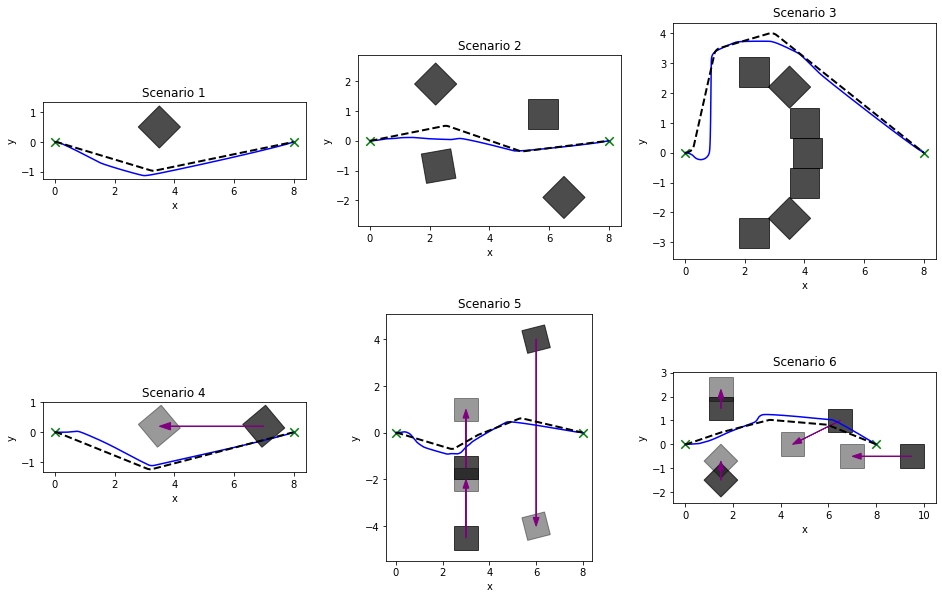

In [17]:
fig = plt.figure(figsize=(16,10))

ax1 = plt.subplot(231)
ax1.set_title("Scenario 1")

ax2 = plt.subplot(232)
ax2.set_title("Scenario 2")

ax3 = plt.subplot(233)
ax3.set_title("Scenario 3")

ax4 = plt.subplot(234)
ax4.set_title("Scenario 4")

ax5 = plt.subplot(235)
ax5.set_title("Scenario 5")

ax6 = plt.subplot(236)
ax6.set_title("Scenario 6")

plot_scenario(scenarios_d[1], df_spb_1.path_all, ax = ax1, size=(8,4))
plot_scenario(scenarios_d[2], df_spb_2.path_all, ax = ax2, size=(8,4))
plot_scenario(scenarios_d[3], df_spb_3.path_all, ax = ax3, size=(8,4))
plot_scenario(scenarios_d[4], df_spb_4.path_all, ax = ax4, size=(8,4))
plot_scenario(scenarios_d[5], df_spb_5.path_all, ax = ax5, size=(8,4))
plot_scenario(scenarios_d[6], df_spb_6.path_all, ax = ax6, size=(8,4))

ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax6.get_legend().remove()

plt.show()

# 3 Comparison to Comparable Planners

## 3.1 Build Dataframe

In [18]:
# For each selected scenario add theoretical paths of all planners
df_comp = pd.DataFrame(columns=["scenario", "name", "final_state", "path_all"])

# Scenario 1
df_comp = df_comp.append({  "scenario": 1,
                            "name":  "potential_fields",
                            "final_state": 1.,
                            "path_all": create_scenario([(2.178,0), (2.892, -0.706), (3.201, -0.938), 
                                                         (3.746, -0.962), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 1,
                            "name":  "ocpBug",
                            "final_state": 1.,
                            "path_all": create_scenario([(3.201, -0.938), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 1,
                            "name":  "tangentBug",
                            "final_state": 1.,
                            "path_all": scenarios_d[1]['ref_path'],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 1,
                            "name":  "spiderBug",
                            "final_state": 1.,
                            "path_all": scenarios_d[1]['ref_path'],
                            }, ignore_index=True)
# Scenario 3
df_comp = df_comp.append({  "scenario": 3,
                            "name":  "potential_fields",
                            "final_state": 1.,
                            "path_all": create_scenario([(2.808,0), (2.806, 1.118), (2.48, 1.47), (1.81, 1.408), 
                                                         (1.187, 1.698), (1, 2.32), (1, 3.32), (1.27, 3.789), 
                                                         (1.731, 3.989), (2.797, 3.992), (3.402, 3.714), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 3,
                            "name":  "ocpBug",
                            "final_state": 1.,
                            "path_all": create_scenario([(1.27, 3.789), (3.402, 3.714), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 3,
                            "name":  "tangentBug",
                            "final_state": 1.,
                            "path_all": create_scenario([(1.042, 3.43), (1.27, 3.789), (1.731, 3.989), 
                                                         (2.797, 3.992), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 3,
                            "name":  "spiderBug",
                            "final_state": 1.,
                            "path_all": scenarios_d[3]['ref_path'],
                            }, ignore_index=True)
# Scenario 4
df_comp = df_comp.append({  "scenario": 4,
                            "name":  "potential_fields",
                            "final_state": 1.,
                            "path_all": create_scenario([(2.3,0), (2.378,0), (2.41, -0.281), (2.564, -0.702), 
                                                         (2.712, -1.014), (3.183, -1.243), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 4,
                            "name":  "ocpBug",
                            "final_state": 1.,
                            "path_all": create_scenario([(0.5, 0), (3, -1.17), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 4,
                            "name":  "tangentBug",
                            "final_state": 1.,
                            "path_all": create_scenario([(0.5, 0), (1.012, -0.08), (1.5, -0.238), (2., -0.5), 
                                                         (2.5, -0.921), (3, -1.17), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 4,
                            "name":  "spiderBug",
                            "final_state": 1.,
                            "path_all": scenarios_d[4]['ref_path'],
                            }, ignore_index=True)
# Scenario 6
df_comp = df_comp.append({  "scenario": 6,
                            "name":  "potential_fields",
                            "final_state": 1.,
                            "path_all": create_scenario([(0.54,0), (0.87, 0.26), (1.5, 0.5), (2.88, 0.39), 
                                                         (2.83, 0.05), (2.72, -0.21), (2.72, 0.58), (3.94, 0.88),
                                                         (5.71, 0.49), (6.37, 0.5), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 6,
                            "name":  "ocpBug",
                            "final_state": 1.,
                            "path_all": create_scenario([(0.32, -0.09), (0.58, -1.58), (1.51, -2.21), 
                                                         (2.5, -2.13), (4.38, -1.7), (8,0)])[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 6,
                            "name":  "tangentBug",
                            "final_state": 2.,
                            "path_all": create_scenario([(0.29, 0), (0.63, 0.06), (0.99, 0.22), (1.5, 0.5), 
                                                         (3.15, 0.46), (3.8, 0.29), (4.24, -0.39), (5, -0.5), 
                                                         (5.76, -0.39), (5.5, 1), (4.17, 0.91), (3.2, 0.28), 
                                                         (2.63, -1.18), (3.39, -1.31), (4.08, -1.22)], add_end=False)[0],
                            }, ignore_index=True)
df_comp = df_comp.append({  "scenario": 6,
                            "name":  "spiderBug",
                            "final_state": 1.,
                            "path_all": scenarios_d[6]['ref_path'],
                            }, ignore_index=True)

In [19]:
# calculate length, av_curvature, tbe
df_comp["length"] = df_comp.apply(lambda row: eval_length([row["path_all"][:, 0], row["path_all"][:, 1]]), axis=1)
df_comp[['av_curvature', 'tbe']] = \
        df_comp.apply(lambda row: eval_smoothness([row["path_all"][:, 0], row["path_all"][:, 1]], row["length"]), axis=1, result_type="expand")
min_max_scaler = preprocessing.MinMaxScaler()
for scen in [1,3,4,6]:
    df_comp.loc[(df_comp['scenario'] == scen), ('length_n', 'av_curvature_n', 'tbe_n')] = \
        min_max_scaler.fit_transform(df_comp.loc[(df_comp['scenario'] == scen)][['length', 'av_curvature', 'tbe']])


## 3.2 Plot Path Comparisons

In [20]:
_df = df_comp.loc[(df_comp['scenario'] == 1)]
_df.loc[:, ('name', 'length_n', 'av_curvature_n', 'tbe_n')].melt(id_vars='name').rename(columns=str.title)

,Name,Variable,Value
0,potential_fields,length_n,1.000000
1,ocpBug,length_n,0.000000
2,tangentBug,length_n,0.127725
3,spiderBug,length_n,0.127725
4,potential_fields,av_curvature_n,1.000000
5,ocpBug,av_curvature_n,0.000000
6,tangentBug,av_curvature_n,0.011900
7,spiderBug,av_curvature_n,0.011900
8,potential_fields,tbe_n,1.000000
9,ocpBug,tbe_n,0.000000


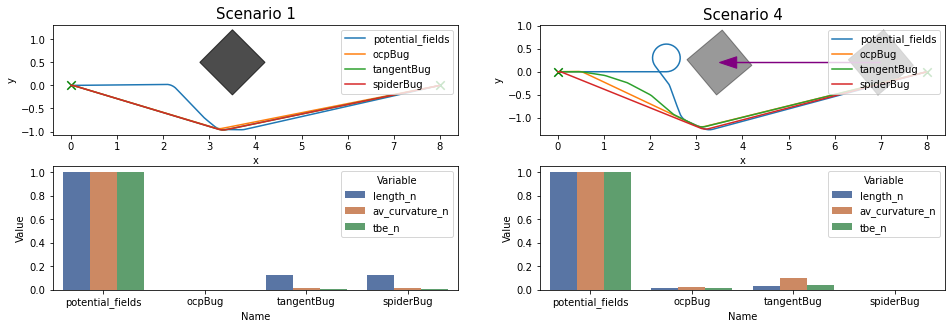

In [21]:
_df_1 = df_comp.loc[(df_comp['scenario'] == 1)]
_df_4 = df_comp.loc[(df_comp['scenario'] == 4)]

fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

# scen 1
plot_paths(scenarios_d[1], _df_1, ax=ax1)
_df_1_t = _df_1.loc[:, ('name', 'length_n', 'av_curvature_n', 'tbe_n')].melt(id_vars='name').rename(columns=str.title)
sns.barplot(x="Name", y="Value", hue='Variable', palette="deep", data=_df_1_t, ax=ax3, color=(102/255, 153/255, 255/255, 0.4))

ax1.legend(loc=1)
ax1.set_title("Scenario 1", fontsize=15)

# scen 4
plot_paths(scenarios_d[4], _df_4, ax=ax2)
_df_2_t = _df_4.loc[:, ('name', 'length_n', 'av_curvature_n', 'tbe_n')].melt(id_vars='name').rename(columns=str.title)
sns.barplot(x="Name", y="Value", hue='Variable', palette="deep", data=_df_2_t, ax=ax4, color=(102/255, 153/255, 255/255, 0.4))


ax2.legend(loc=1)
ax2.set_title("Scenario 4", fontsize=15)


plt.show()

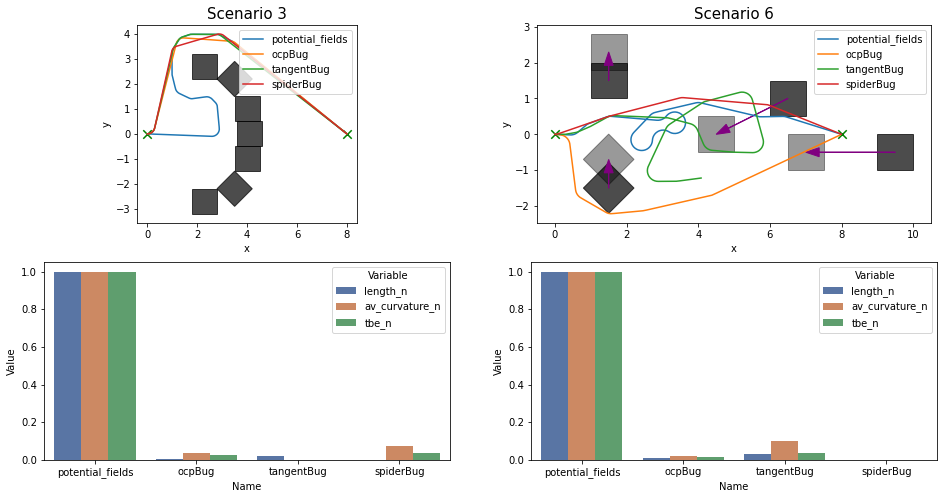

In [22]:
_df_3 = df_comp.loc[(df_comp['scenario'] == 3)]
_df_6 = df_comp.loc[(df_comp['scenario'] == 6)]

fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

# scen 3
plot_paths(scenarios_d[3], _df_3, ax=ax1)
_df_3_t = _df_3.loc[:, ('name', 'length_n', 'av_curvature_n', 'tbe_n')].melt(id_vars='name').rename(columns=str.title)
sns.barplot(x="Name", y="Value", hue='Variable', palette="deep", data=_df_3_t, ax=ax3, color=(102/255, 153/255, 255/255, 0.4))

ax1.legend(loc=1)
ax1.set_title("Scenario 3", fontsize=15)

# scen 6
plot_paths(scenarios_d[6], _df_6, ax=ax2)
_df_6_t = _df_4.loc[:, ('name', 'length_n', 'av_curvature_n', 'tbe_n')].melt(id_vars='name').rename(columns=str.title)
sns.barplot(x="Name", y="Value", hue='Variable', palette="deep", data=_df_6_t, ax=ax4, color=(102/255, 153/255, 255/255, 0.4))


ax2.legend(loc=1)
ax2.set_title("Scenario 6", fontsize=15)


plt.show()

# 4. Hyper-Parameter Experiment
## 4.1 Load the Data

In [23]:
df_tol, df_tol_1, df_tol_2, df_tol_3, df_tol_4, df_tol_5, df_tol_6, _ = \
    load_data(["H_TOL", "D_TOL"], "TOL", "tolerances")

In [24]:
df_res, df_res_1, df_res_2, df_res_3, df_res_4, df_res_5, df_res_6, _ = \
    load_data(["RES_HORIZONTAL"], "RES", "resolutions")

In [25]:
# normalise the final state
min_max_scaler = preprocessing.MinMaxScaler()
df_res['final_state_n'] = min_max_scaler.fit_transform(df_res[['final_state']])

## 4.2 Plot the Data

### 4.2.1 Resolutions

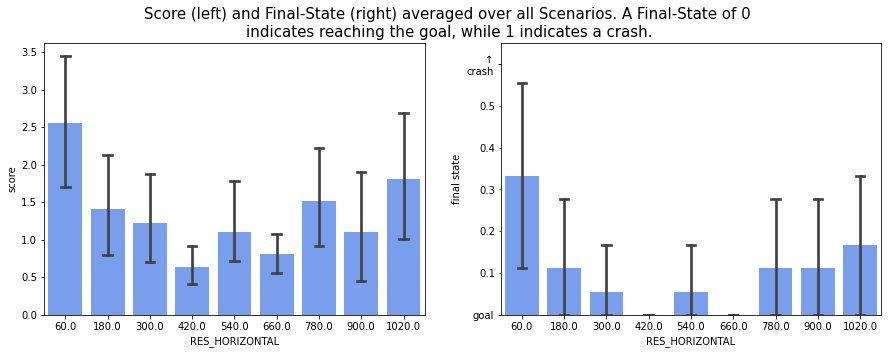

In [26]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121) # , figsize=(10, 5)
ax2 = plt.subplot(122)

ax1 = sns.barplot(x="RES_HORIZONTAL", y="score", data=df_res, capsize=.2, ax=ax1, color=(102/255, 153/255, 255/255, 0.4))

ax2 = sns.barplot(x="RES_HORIZONTAL", y="final_state_n", data=df_res, capsize=.2, ax=ax2, color=(102/255, 153/255, 255/255, 0.4))
ax2.set_yticks([0., .6])
ax2.set_yticklabels(["goal", "↑\ncrash"])
ax2.set_yticks(np.around(np.arange(0.1, 0.6, 0.1), decimals=1), minor=True)
ax2.set_yticklabels(np.around(np.arange(0.1, 0.6, 0.1), decimals=1), minor=True)
ax2.set_ylabel("final state")
ax2.set_ylim(0, 0.65)
# (0 indicates reaching the goal, while 1 \nindicates a crash)

fig.suptitle("Score (left) and Final-State (right) averaged over all Scenarios. A Final-State of 0 \nindicates reaching the goal, while 1 indicates a crash.", fontsize=15)
plt.show()

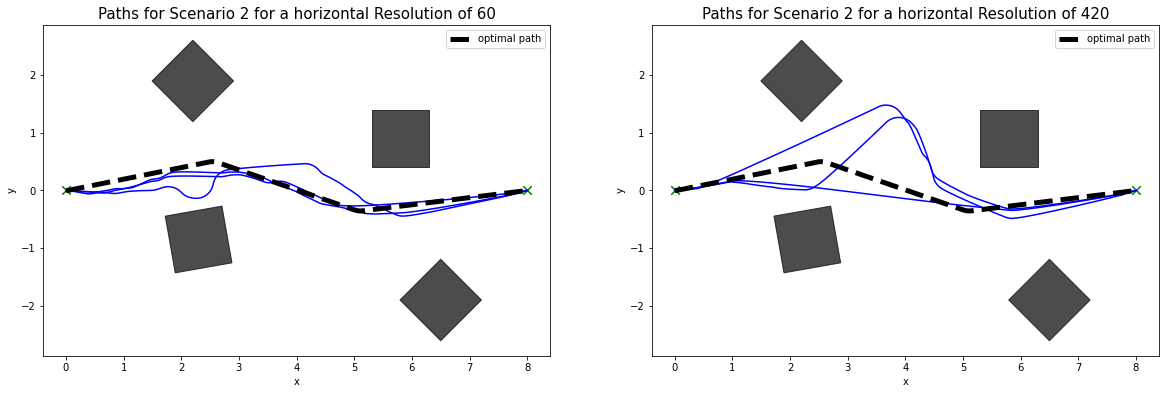

In [27]:
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


plot_scenario(scenarios_d[2], df_res_2.loc[(df_res['RES_HORIZONTAL'] == 60), 'path_all'], ax=ax1)
ax1.set_title("Paths for Scenario 2 for a horizontal Resolution of 60", fontsize=15)
#ax1.set_ylim(-2, 2)

plot_scenario(scenarios_d[2], df_res_2.loc[(df_res['RES_HORIZONTAL'] == 420), 'path_all'], ax=ax2)
ax2.set_title("Paths for Scenario 2 for a horizontal Resolution of 420", fontsize=15)
#ax2.set_ylim(-2, 2)

plt.show()

### 4.2.2 Tolerances

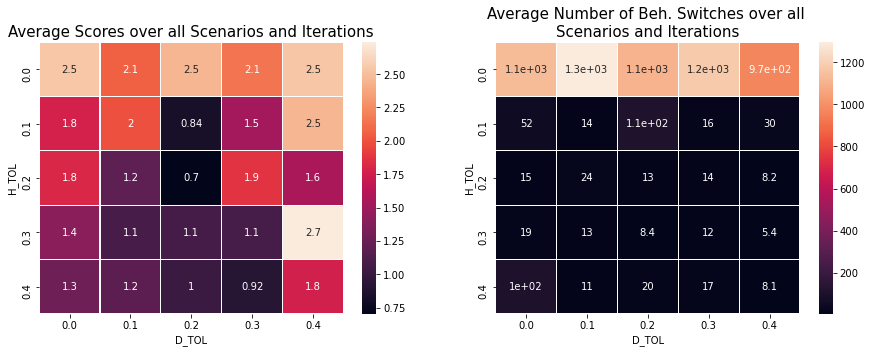

In [28]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(121) # , figsize=(10, 5)
ax2 = plt.subplot(122)

ax1 = plt_heatmap_mult(df_tol, [1,2,3,4,5,6], "score", ax=ax1)
ax1.set_title('Average Scores over all Scenarios and Iterations', fontsize = 15) 

ax2 = plt_heatmap_mult(df_tol, [1,2,3,4,5,6], "n_switches", ax=ax2)
ax2.set_title("Average Number of Beh. Switches over all \nScenarios and Iterations", fontsize = 15)

plt.show()

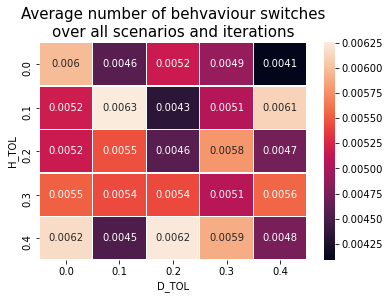

In [29]:
plt_heatmap_mult(df_tol, [1,2,3,4,5,6], "av_curvature")
plt.title('Average number of behvaviour switches\nover all scenarios and iterations', fontsize = 15) 
plt.show()

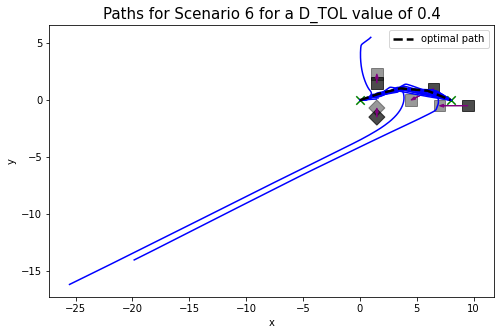

In [30]:
plot_scenario(scenarios_d[6], df_tol_6.loc[(df_tol_6['D_TOL'] == 0.4), 'path_all'], size=(10, 5))
plt.title("Paths for Scenario 6 for a D_TOL value of 0.4", fontsize=15)
plt.show()

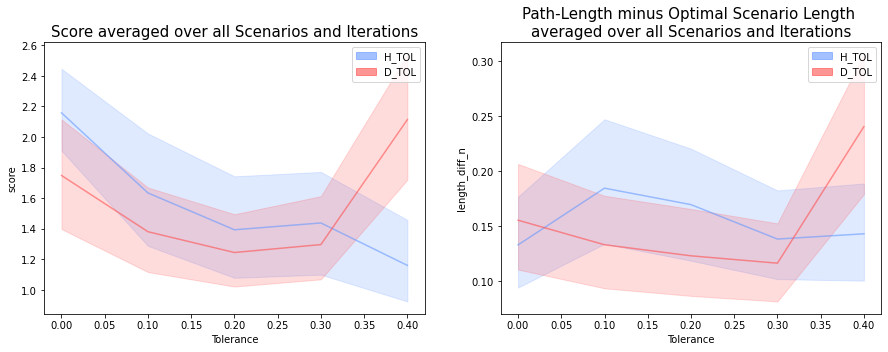

In [31]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(121) # , figsize=(10, 5)
ax2 = plt.subplot(122)

# seaborn plots
ax1 = sns.lineplot(x="H_TOL", y="score", data=df_tol, color=(102/255, 153/255, 255/255, 0.6), ax=ax1, markers=True)
ax1 = sns.lineplot(x="D_TOL", y="score", data=df_tol, color=(255/255, 80/255, 80/255, 0.6), ax=ax1, markers=True)

# matplotlib elements
ax1.set_xlabel("Tolerance")
ax1.set_title("Score averaged over all Scenarios and Iterations", fontsize=15)
patch_0 = mpatches.Patch(color=(102/255, 153/255, 255/255, 0.6), label='H_TOL')
patch_1 = mpatches.Patch(color=(255/255, 80/255, 80/255, 0.6), label='D_TOL')
ax1.legend(handles=[patch_0, patch_1])

# seaborn plots
ax2 = sns.lineplot(x="H_TOL", y="length_diff_n", data=df_tol, color=(102/255, 153/255, 255/255, 0.6), ax=ax2, markers=True)
ax2 = sns.lineplot(x="D_TOL", y="length_diff_n", data=df_tol, color=(255/255, 80/255, 80/255, 0.6), ax=ax2, markers=True)

ax2.set_xlabel("Tolerance")
ax2.set_title("Path-Length minus Optimal Scenario Length \naveraged over all Scenarios and Iterations", fontsize=15)
ax2.legend(handles=[patch_0, patch_1])


plt.show()

# 5. Vehicular Model Experiment
## 5.1 Load the Data

In [32]:
df_mod, df_mod_1, df_mod_2, df_mod_3, df_mod_4, df_mod_5, df_mod_6, _ = \
    load_data(["ROB_MODEL"], "MOD", "models", eval_s=False)
# label the robots
df_mod.loc[(df_mod['ROB_MODEL'] == 1), 'ROB_MODEL'] = "Det. Holonomic"
df_mod.loc[(df_mod['ROB_MODEL'] == 0), 'ROB_MODEL'] = "Det. Nonholonomic"
df_mod.loc[(df_mod['ROB_MODEL'] == 2), 'ROB_MODEL'] = "Nondet. Holonomic"

In [33]:
# normalise the score and final-state
min_max_scaler = preprocessing.MinMaxScaler()
df_mod['score_n'] = min_max_scaler.fit_transform(df_mod[['score']])
df_mod['final_state_n'] = min_max_scaler.fit_transform(df_mod[['final_state']])

## 5.2 Plot the Data

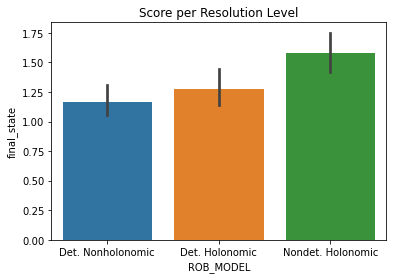

In [34]:
ax = sns.barplot(x="ROB_MODEL", y="final_state", data=df_mod)
ax.set_title("Score per Resolution Level")
plt.show()

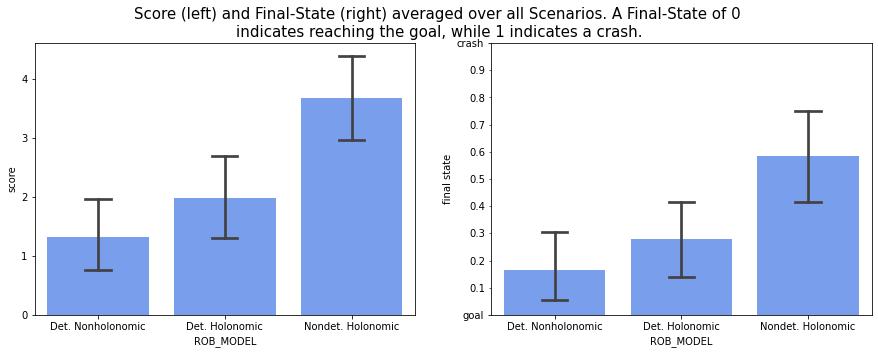

In [35]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121) # , figsize=(10, 5)
ax2 = plt.subplot(122)

ax1 = sns.barplot(x="ROB_MODEL", y="score", data=df_mod, capsize=.2, ax=ax1, color=(102/255, 153/255, 255/255, 0.4))

ax2 = sns.barplot(x="ROB_MODEL", y="final_state_n", data=df_mod, capsize=.2, ax=ax2, color=(102/255, 153/255, 255/255, 0.4))
ax2.set_yticks([0., 1])
ax2.set_yticklabels(["goal", "crash"])
ax2.set_yticks(np.around(np.arange(0.1, 1, 0.1), decimals=1), minor=True)
ax2.set_yticklabels(np.around(np.arange(0.1, 1, 0.1), decimals=1), minor=True)
ax2.set_ylabel("final state")
ax2.set_ylim(0, 1)
# (0 indicates reaching the goal, while 1 \nindicates a crash)

fig.suptitle("Score (left) and Final-State (right) averaged over all Scenarios. A Final-State of 0 \nindicates reaching the goal, while 1 indicates a crash.", fontsize=15)
plt.show()

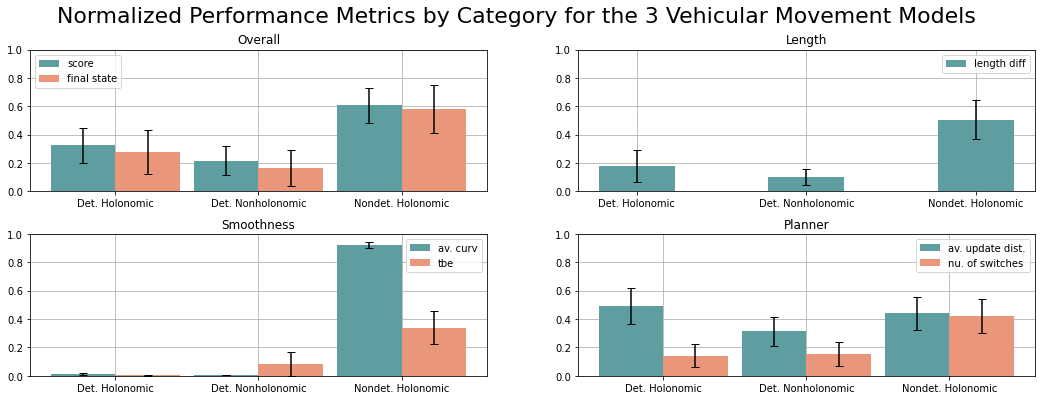

In [36]:
barWidth = 0.45

fig = plt.figure(figsize=(18,6))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

ax1.grid(zorder=0)
ax2.grid(zorder=0)
ax3.grid(zorder=0)
ax4.grid(zorder=0)

models = ["Det. Holonomic", "Det. Nonholonomic", "Nondet. Holonomic"]
models_i = np.arange(0, 3)
df_t = df_mod.groupby(['ROB_MODEL']).mean()

y_err_1 = [mean_confidence_interval(df_mod.loc[(df_mod['ROB_MODEL'] == i), 'score_n']) for i in models]
y_err_2_1 = [mean_confidence_interval(df_mod.loc[(df_mod['ROB_MODEL'] == i), 'final_state_n']) for i in models]
ax1.bar(models_i-barWidth/2, df_t.score_n, width=barWidth, label="score", yerr=y_err_1, capsize=4, zorder=3, color="CadetBlue")
ax1.bar(models_i+barWidth/2, df_t.final_state_n, width=barWidth, label="final state", yerr=y_err_2_1, capsize=4, zorder=3, color="DarkSalmon")

y_err_2 = [mean_confidence_interval(df_mod.loc[(df_mod['ROB_MODEL'] == i), 'length_diff_n']) for i in models]
ax2.bar(models_i, df_t.length_diff_n, width=barWidth, label="length diff", yerr=y_err_2, capsize=4, zorder=3, color="CadetBlue")

y_err_3 = [mean_confidence_interval(df_mod.loc[(df_mod['ROB_MODEL'] == i), 'av_curvature_n']) for i in models]
y_err_3_1 = [mean_confidence_interval(df_mod.loc[(df_mod['ROB_MODEL'] == i), 'tbe_n']) for i in models]
ax3.bar(models_i-barWidth/2, df_t.av_curvature_n, width=barWidth, label="av. curv", yerr=y_err_3, capsize=4, zorder=3, color="CadetBlue")
ax3.bar(models_i+barWidth/2, df_t.tbe_n, width=barWidth, label="tbe", yerr=y_err_3_1, capsize=4, zorder=3, color="DarkSalmon")

y_err_4 = [mean_confidence_interval(df_mod.loc[(df_mod['ROB_MODEL'] == i), 'av_update_dist_n']) for i in models]
y_err_4_1 = [mean_confidence_interval(df_mod.loc[(df_mod['ROB_MODEL'] == i), 'n_switches_n']) for i in models]
ax4.bar(models_i-barWidth/2, df_t.av_update_dist_n, width=barWidth, label="av. update dist.", yerr=y_err_4, capsize=4, zorder=3, color="CadetBlue")
ax4.bar(models_i+barWidth/2, df_t.n_switches_n, width=barWidth, label="nu. of switches", yerr=y_err_4_1, capsize=4, zorder=3, color="DarkSalmon")

ax1.set_title("Overall")
ax3.set_title("Smoothness")
ax4.set_title("Planner")
ax2.set_title("Length")

ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax3.set_ylim(0,1)
ax4.set_ylim(0,1)

ax1.set_xticks(models_i)
ax1.set_xticklabels(models)
ax2.set_xticks(models_i)
ax2.set_xticklabels(models)
ax3.set_xticks(models_i)
ax3.set_xticklabels(models)
ax4.set_xticks(models_i)
ax4.set_xticklabels(models)


ax1.legend(loc=0)
ax2.legend(loc=1)
ax3.legend(loc=0)
ax4.legend(loc=0)

fig.suptitle("Normalized Performance Metrics by Category for the 3 Vehicular Movement Models", fontsize=22, )
fig.subplots_adjust(hspace = 0.3) 
plt.show()

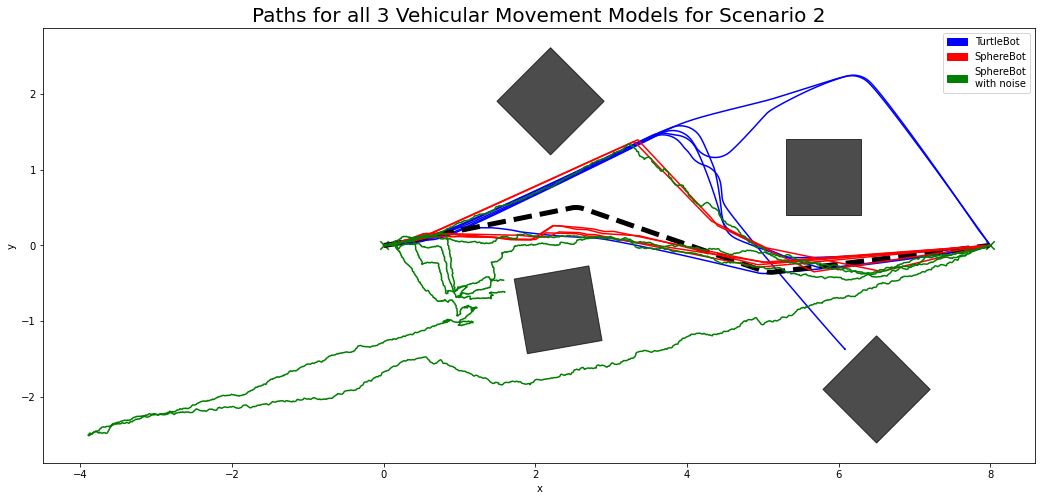

In [37]:
def my_plot(scen, _df):
    fig = plt.figure(figsize=(20,8))
    ax1 = plt.subplot(111)

    plot_scenario(scenarios_d[scen], _df.loc[(_df['ROB_MODEL'] == 0), 'path_all'], ax=ax1)
    #ax1.set_ylim(-2, 2)
    plot_scenario(scenarios_d[scen], _df.loc[(_df['ROB_MODEL'] == 1), 'path_all'], ax=ax1, col="red", only_paths=True)
    plot_scenario(scenarios_d[scen], _df.loc[(_df['ROB_MODEL'] == 2), 'path_all'], ax=ax1, col="green", only_paths=True)

    patch_0 = mpatches.Patch(color="blue", label='TurtleBot')
    patch_1 = mpatches.Patch(color="red", label='SphereBot')
    patch_2 = mpatches.Patch(color="green", label='SphereBot\nwith noise')

    plt.legend(handles=[patch_0, patch_1, patch_2])
    plt.title("Paths for all 3 Vehicular Movement Models for Scenario " + str(scen), fontsize=20)

    plt.show()
my_plot(2, df_mod_2)

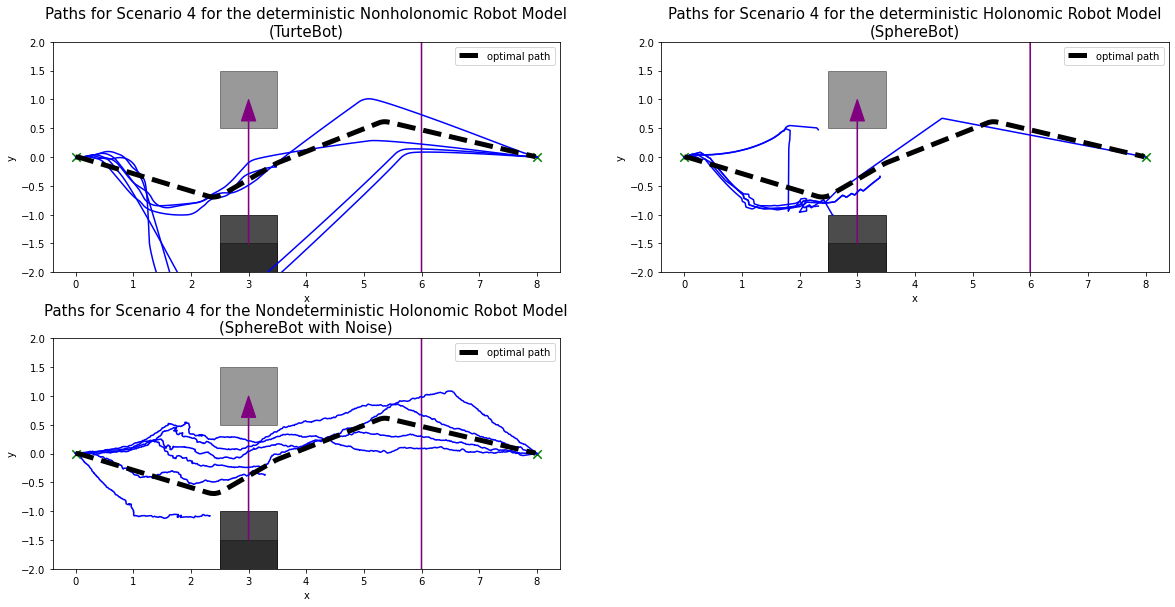

In [38]:
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)


plot_scenario(scenarios_d[5], df_mod_5.loc[(df_mod_5['ROB_MODEL'] == 0), 'path_all'], ax=ax1)
ax1.set_title("Paths for Scenario 4 for the deterministic Nonholonomic Robot Model\n(TurteBot)", fontsize=15)
ax1.set_ylim(-2, 2)

plot_scenario(scenarios_d[5], df_mod_5.loc[(df_mod_5['ROB_MODEL'] == 1), 'path_all'], ax=ax2)
ax2.set_title("Paths for Scenario 4 for the deterministic Holonomic Robot Model\n(SphereBot)", fontsize=15)
ax2.set_ylim(-2, 2)

plot_scenario(scenarios_d[5], df_mod_5.loc[(df_mod_5['ROB_MODEL'] == 2), 'path_all'], ax=ax3)
ax3.set_title("Paths for Scenario 4 for the Nondeterministic Holonomic Robot Model\n(SphereBot with Noise)", fontsize=15)
ax3.set_ylim(-2, 2)

plt.show()

# 6. Dynamic Environment Experiment
## 6.1 Load the Data

In [39]:
df_obs, _, _, _, _, _, _, df_obst_7 = \
    load_data(["O_M"], "OBS", "obstacles", scenarios=[7])

In [40]:
# normalise the score and final-state
min_max_scaler = preprocessing.MinMaxScaler()
df_obs['score_n'] = min_max_scaler.fit_transform(df_obs[['score']])
df_obs['final_state_n'] = min_max_scaler.fit_transform(df_obs[['final_state']])

## 6.2 Plot the Data

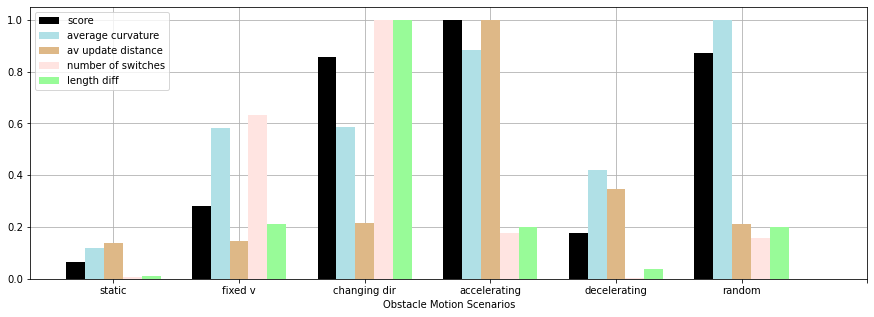

In [41]:
barWidth = 0.15

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(111)
ax1.grid(zorder=0)

ax1.bar(df_obs.O_M, df_obs.score_n, width=barWidth, label="score", zorder=3, color="black")
ax1.bar(df_obs.O_M+1*barWidth, df_obs.av_curvature_n, width=barWidth, label="average curvature", zorder=3, color="PowderBlue")
ax1.bar(df_obs.O_M+2*barWidth, df_obs.av_update_dist_n, width=barWidth, label="av update distance", zorder=3, color="BurlyWood")
ax1.bar(df_obs.O_M+3*barWidth, df_obs.n_switches_n, width=barWidth, label="number of switches", zorder=3, color="MistyRose")
ax1.bar(df_obs.O_M+4*barWidth, df_obs.length_diff_n, width=barWidth, label="length diff", zorder=3, color="PaleGreen")
# 

ax1.set_xlabel('Obstacle Motion Scenarios')
ax1.set_xticks([r + 2*barWidth for r in range(7)])
ax1.set_xticklabels(['static', 'fixed v', 'changing dir', 'accelerating', 'decelerating', 'random'])

ax1.legend()
plt.show()


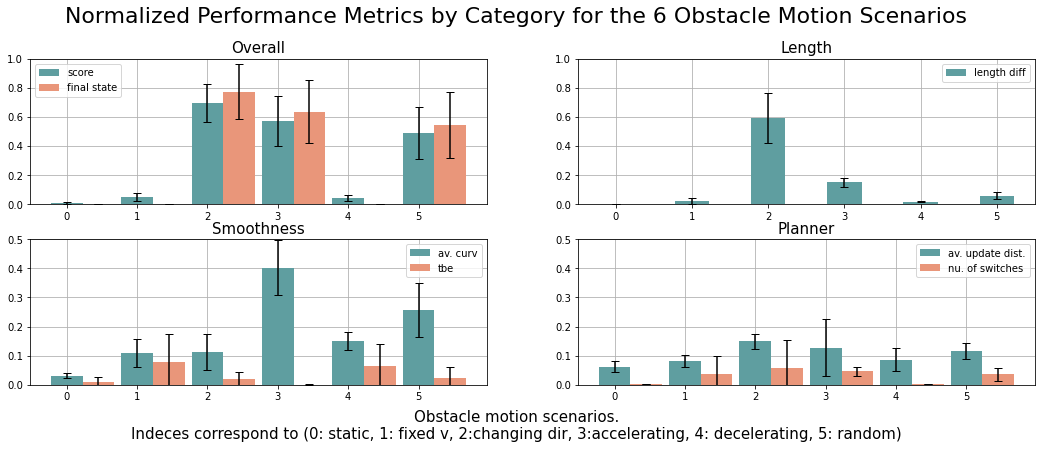

In [42]:
barWidth = 0.45

fig = plt.figure(figsize=(18,6))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

ax1.grid(zorder=0)
ax2.grid(zorder=0)
ax3.grid(zorder=0)
ax4.grid(zorder=0)

df_t = df_obs.groupby(['O_M']).mean()

y_err_1 = [mean_confidence_interval(df_obs.loc[(df_obs['O_M'] == i), 'score_n']) for i in range(6)]
y_err_2_1 = [mean_confidence_interval(df_obs.loc[(df_obs['O_M'] == i), 'final_state_n']) for i in range(6)]
ax1.bar(df_t.index, df_t.score_n, width=barWidth, label="score", yerr=y_err_1, capsize=4, zorder=3, color="CadetBlue")
ax1.bar(df_t.index+barWidth, df_t.final_state_n, width=barWidth, label="final state", yerr=y_err_2_1, capsize=4, zorder=3, color="DarkSalmon")

y_err_2 = [mean_confidence_interval(df_obs.loc[(df_obs['O_M'] == i), 'length_diff_n']) for i in range(6)]
ax2.bar(df_t.index, df_t.length_diff_n, width=barWidth, label="length diff", yerr=y_err_2, capsize=4, zorder=3, color="CadetBlue")

y_err_3 = [mean_confidence_interval(df_obs.loc[(df_obs['O_M'] == i), 'av_curvature_n']) for i in range(6)]
y_err_3_1 = [mean_confidence_interval(df_obs.loc[(df_obs['O_M'] == i), 'tbe_n']) for i in range(6)]
ax3.bar(df_t.index, df_t.av_curvature_n, width=barWidth, label="av. curv", yerr=y_err_3, capsize=4, zorder=3, color="CadetBlue")
ax3.bar(df_t.index+barWidth, df_t.tbe_n, width=barWidth, label="tbe", yerr=y_err_3_1, capsize=4, zorder=3, color="DarkSalmon")

y_err_4 = [mean_confidence_interval(df_obs.loc[(df_obs['O_M'] == i), 'av_update_dist_n']) for i in range(6)]
y_err_4_1 = [mean_confidence_interval(df_obs.loc[(df_obs['O_M'] == i), 'n_switches_n']) for i in range(6)]
ax4.bar(df_t.index, df_t.av_update_dist_n, width=barWidth, label="av. update dist.", yerr=y_err_4, capsize=4, zorder=3, color="CadetBlue")
ax4.bar(df_t.index+barWidth, df_t.n_switches_n, width=barWidth, label="nu. of switches", yerr=y_err_4_1, capsize=4, zorder=3, color="DarkSalmon")


# ['static', 'fixed v', 'changing dir', 'accelerating', 'decelerating', 'random']

ax1.set_title("Overall", fontsize=15)
ax3.set_title("Smoothness", fontsize=15)
ax4.set_title("Planner", fontsize=15)
ax2.set_title("Length", fontsize=15)

ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax3.set_ylim(0,.5)
ax4.set_ylim(0,.5)

ax1.legend(loc=0)
ax2.legend(loc=1)
ax3.legend(loc=0)
ax4.legend(loc=0)

fig.text(0.5, -0.0, 'Obstacle motion scenarios.\nIndeces correspond to (0: static, 1: fixed v, 2:changing dir, 3:accelerating, 4: decelerating, 5: random)', ha='center', fontsize=15)
fig.suptitle("Normalized Performance Metrics by Category for the 6 Obstacle Motion Scenarios", fontsize=22, y = 1.0)
fig.subplots_adjust(hspace = 0.24) 
plt.show()

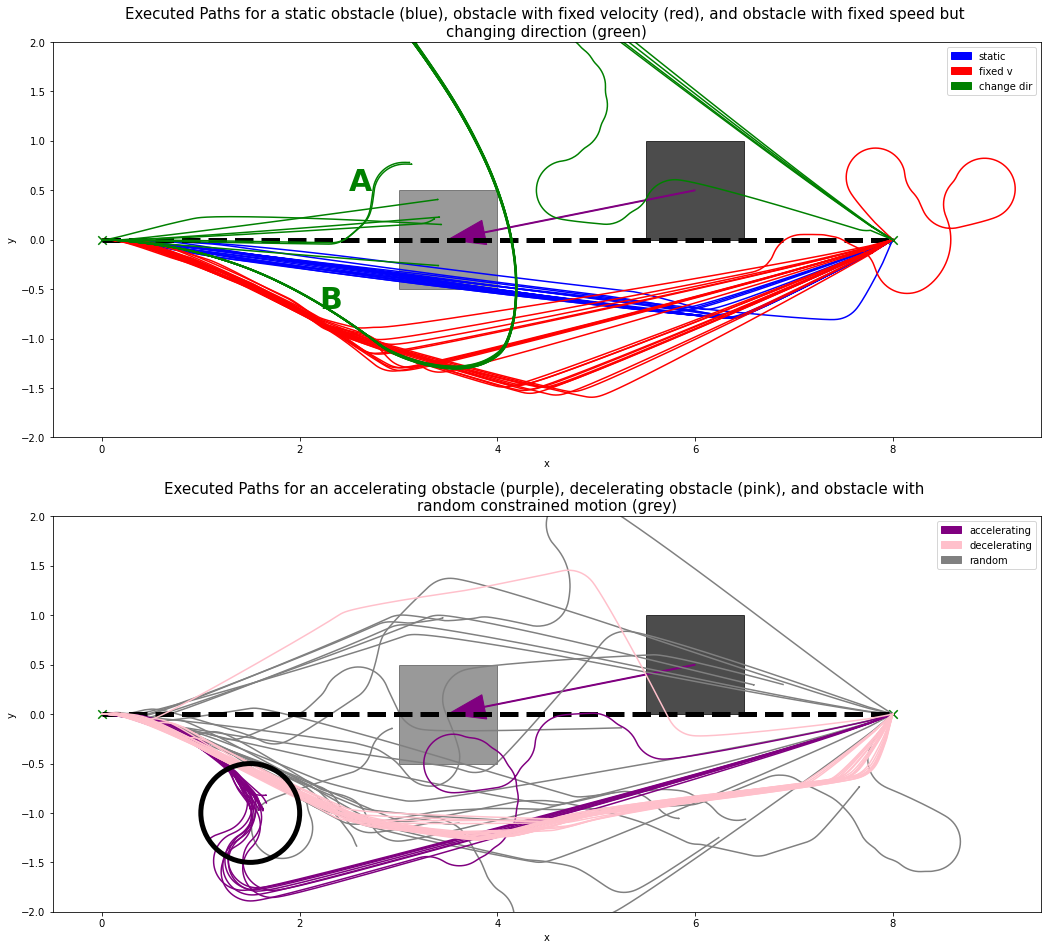

In [43]:
fig = plt.figure(figsize=(20,16))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

plot_scenario(scenarios_d[7], df_obs.loc[(df_obs['O_M'] == 0), 'path_all'], ax=ax1, col="blue")
plot_scenario(scenarios_d[7], df_obs.loc[(df_obs['O_M'] == 1), 'path_all'], ax=ax1, col="red", only_paths=True)
plot_scenario(scenarios_d[7], df_obs.loc[(df_obs['O_M'] == 2), 'path_all'], ax=ax1, col="green", only_paths=True)

plot_scenario(scenarios_d[7], df_obs.loc[(df_obs['O_M'] == 5), 'path_all'], ax=ax2, col="grey")
plot_scenario(scenarios_d[7], df_obs.loc[(df_obs['O_M'] == 3), 'path_all'], ax=ax2, col="purple", only_paths=True)
plot_scenario(scenarios_d[7], df_obs.loc[(df_obs['O_M'] == 4), 'path_all'], ax=ax2, col="pink", only_paths=True)

patch_0 = mpatches.Patch(color="blue", label='static')
patch_1 = mpatches.Patch(color="red", label='fixed v')
patch_2 = mpatches.Patch(color="green", label='change dir')

patch_3 = mpatches.Patch(color="purple", label='accelerating')
patch_4 = mpatches.Patch(color="pink", label='decelerating')
patch_5 = mpatches.Patch(color="grey", label='random')

circle = plt.Circle((1.5, -1), 0.5, linewidth=5, color='black', fill=False, zorder=5)
ax2.add_artist(circle)
ax1.text(2.5, 0.5, "A", fontsize=30, fontdict ={'fontweight':'bold', 'color':'green'})
ax1.text(2.2, -0.7, "B", fontsize=30, fontdict ={'fontweight':'bold', 'color':'green'})

ax1.set_ylim(-2,2)
ax1.set_xlim(-.5,9.5)

ax2.set_ylim(-2,2)
ax2.set_xlim(-.5,9.5)

ax1.legend(handles=[patch_0, patch_1, patch_2])
ax2.legend(handles=[patch_3, patch_4, patch_5])

ax1.set_title("Executed Paths for a static obstacle (blue), obstacle with fixed velocity (red), and obstacle with fixed speed but \nchanging direction (green)", fontsize=15)
ax2.set_title("Executed Paths for an accelerating obstacle (purple), decelerating obstacle (pink), and obstacle with \nrandom constrained motion (grey)", fontsize=15)

plt.show()

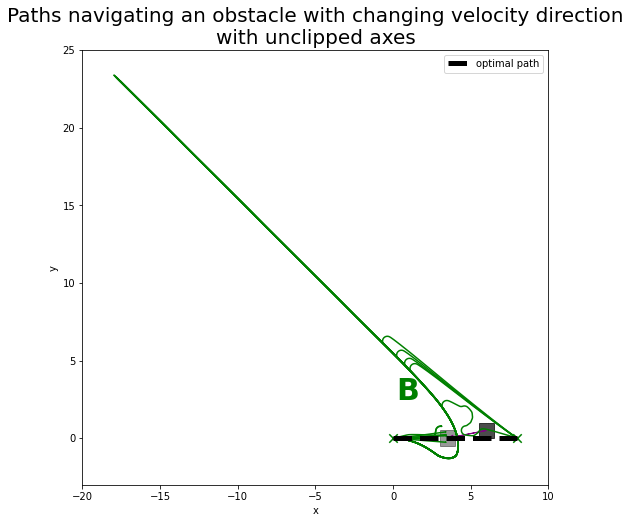

In [44]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(111)

plot_scenario(scenarios_d[7], df_obs.loc[(df_obs['O_M'] == 2), 'path_all'], ax=ax1, col="green")

ax1.set_ylim(-3,25)
ax1.set_xlim(-20,10)

ax1.text(0.2, 2.5, "B", fontsize=30, fontdict ={'fontweight':'bold', 'color':'green'})

ax1.set_title("Paths navigating an obstacle with changing velocity direction\nwith unclipped axes", fontsize=20)
plt.show()

# 7. Performance Experiment
## 7.1 Load the Data

In [45]:
base_dir = "exp_data\\"
f_name = str(base_dir) + "perf.csv"
df_perf = pd.DataFrame(columns=["language", "presorting", "caching", "early_exit", "intersecting", "total_time"])
with open(f_name, newline='') as csvfile:
    csvReader = csv.reader(csvfile, delimiter=';')
    for j, row in enumerate(csvReader):
        if j != 0:
            df_perf = df_perf.append({
                        "language": row[0],
                        "presorting":  bool(int(row[1])),
                        "caching": bool(int(row[2])),
                        "early_exit": bool(int(row[3])),
                        "intersecting": bool(int(row[4])),
                        "total_time": float(row[5]) 
                        }, ignore_index=True)

In [46]:
# assign labels
def assign_label(row):
    if row["presorting"] and not row["caching"] and not row["early_exit"]:
        return "presorting"
    if row["caching"] and not row["presorting"] and not row["early_exit"]:
        return "caching"
    if row["presorting"] and row["early_exit"] and not row["caching"]:
        return "presorting and\nearly exit"
    if row["presorting"] and row["caching"] and row["early_exit"]:
        return "all"
    return "none"
        
df_perf["optimisation"] = df_perf.apply(lambda row: assign_label(row), axis=1)

df_perf

,language,presorting,caching,early_exit,intersecting,total_time,optimisation
0,Pure python,False,False,False,True,73.26,none
1,Pure python,False,False,False,False,116.58,none
2,Pure python,True,False,False,True,3.15,presorting
3,Pure python,True,False,False,False,119.28,presorting
4,Pure python,True,False,True,True,3.23,presorting and\nearly exit
5,Pure python,True,False,True,False,3.02,presorting and\nearly exit
6,Pure python,False,True,False,True,66.63,caching
7,Pure python,False,True,False,False,104.35,caching
8,Python with cython backend,False,False,False,True,70.31,none
9,Python with cython backend,False,False,False,False,97.30,none


## 7.2 Plot the Data

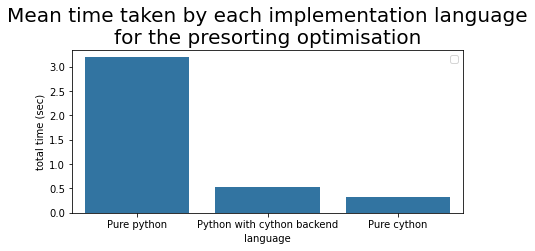

In [47]:
fig = plt.figure(figsize=(7, 3))
ax1 = plt.subplot(111)

sns.barplot(x="language", y="total_time", hue="intersecting", data=df_perf.loc[(df_perf['presorting'] == True) & (df_perf['intersecting'] == True)], ci=None, ax=ax1)

ax1.set_title("Mean time taken by each implementation language\nfor the presorting optimisation", fontsize=20)
ax1.set_ylabel("total time (sec)")
ax1.legend([])
plt.show()

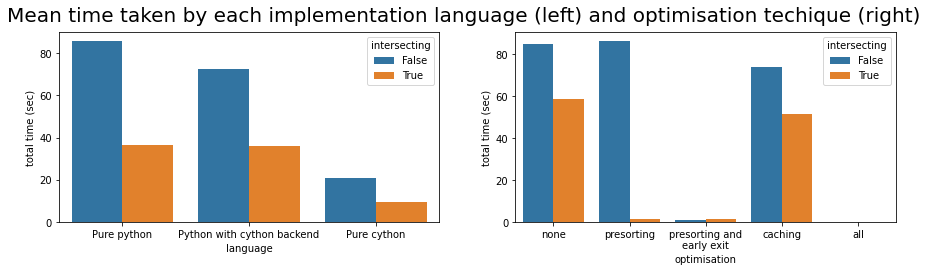

In [48]:
fig = plt.figure(figsize=(15, 3.5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

sns.barplot(x="language", y="total_time", hue="intersecting", data=df_perf, ci=None, ax=ax1)
sns.barplot(x="optimisation", y="total_time", hue="intersecting", data=df_perf, ci=None, ax=ax2)

#ax1.set_title("Mean time taken by each implementation language", fontsize=20)
#ax2.set_title("Mean time taken by each optimisation techique", fontsize=20)
fig.suptitle("Mean time taken by each implementation language (left) and optimisation techique (right)", fontsize=20)


ax1.set_ylabel("total time (sec)")
ax2.set_ylabel("total time (sec)")

plt.show()